In [1]:
#import libraries
from os import path

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12,8

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import xgboost as xgb


#Common Model Helpers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score

#stacking
from sklearn.model_selection import KFold

#hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings('ignore')

#set directory
DATA_DIR = '/Users/Alastair/Desktop/python/kaggle/Spaceship Titanic'

In [2]:
#load data
train = pd.read_csv(path.join(DATA_DIR,"train_wrangled.csv"))
test = pd.read_csv(path.join(DATA_DIR,"test_wrangled.csv"))
MLA_predict = pd.read_csv(path.join(DATA_DIR,"MLA_predict.csv"))

#combine test and train dfs for easy manipulation
combine = [train, test]

In [3]:
# preview the data
train.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,SpaBin,VRDeckBin,places_spent,total_spend_log,RoomServiceLog,FoodCourtLog,ShoppingMallLog,SpaLog,VRDeckLog,AgeBin
7311,7828_01,1,1,G/1266/S,0,28.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,2
6202,6558_01,1,0,F/1363/P,0,31.0,0.0,3.0,0.0,0.0,...,1.0,1.0,3.0,2,0,0,0,2,1,2
6475,6829_03,1,1,G/1109/P,0,32.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,2
6522,6889_01,1,0,F/1317/S,0,40.0,0.0,862.0,0.0,0.0,...,0.0,1.0,2.0,2,2,0,0,0,1,3
5910,6268_01,2,1,F/1202/S,0,33.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,2
2044,2189_01,1,0,G/354/P,0,34.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2,0,0,0,2,0,2
5536,5901_01,1,0,F/1221/P,2,15.0,0.0,0.0,40.0,0.0,...,0.0,1.0,2.0,2,0,1,0,0,2,0
1770,1882_01,0,0,C/71/S,2,18.0,0.0,0.0,16263.0,72.0,...,0.0,1.0,3.0,4,0,4,1,0,1,0
4596,4897_01,1,0,F/993/P,0,18.0,0.0,0.0,0.0,31.0,...,1.0,0.0,2.0,3,0,0,1,3,0,0
3094,3332_03,2,1,D/107/S,2,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Labelling

Assigning new variables to help with ML and graphing

In [4]:
#define y variable aka target/outcome
Target = ['Transported']

#define x variables for original features aka feature selection
x = ['HomePlanet','CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name_length', 'total_spend', 'group','deck']
xy = Target + x
print('Original X Y: ', xy, '\n')


#define x variables for original w/bin features to remove continuous variables
#with binary spend colums
#x_bin = ['HomePlanet','CryoSleep', 'Destination', 'AgeBin', 'VIP', 'RoomServiceBin', 'FoodCourtBin', 'ShoppingMallBin', 'SpaBin', 'VRDeckBin', 'has_spent', 'is_alone','deck'] #pretty name/values for charts
#with Log10 spend columns
x_bin = ['HomePlanet','CryoSleep', 'Destination', 'AgeBin', 'RoomServiceLog', 'FoodCourtLog', 'ShoppingMallLog', 'SpaLog', 'VRDeckLog', 'total_spend_log','deck'] #pretty name/values for charts
xy_bin =  Target + x_bin
print('Bin X Y: ', xy_bin, '\n')

#setting bin variables to int
for x in x_bin:
    train[x] = train[x].astype(int)
    test[x] = test[x].astype(int)

Original X Y:  ['Transported', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name_length', 'total_spend', 'group', 'deck'] 

Bin X Y:  ['Transported', 'HomePlanet', 'CryoSleep', 'Destination', 'AgeBin', 'RoomServiceLog', 'FoodCourtLog', 'ShoppingMallLog', 'SpaLog', 'VRDeckLog', 'total_spend_log', 'deck'] 



# Ensemble Stacking

For this submission I used an ensemble stack to try and harness the capabilities of a range of well-performing models to make predictions that have better performance than any single model in the ensemble.

I prepared the training dataset for the meta-model using k-fold cross-validation of the base models, where the out-of-fold predictions were used as the basis for the training dataset for the meta-model.

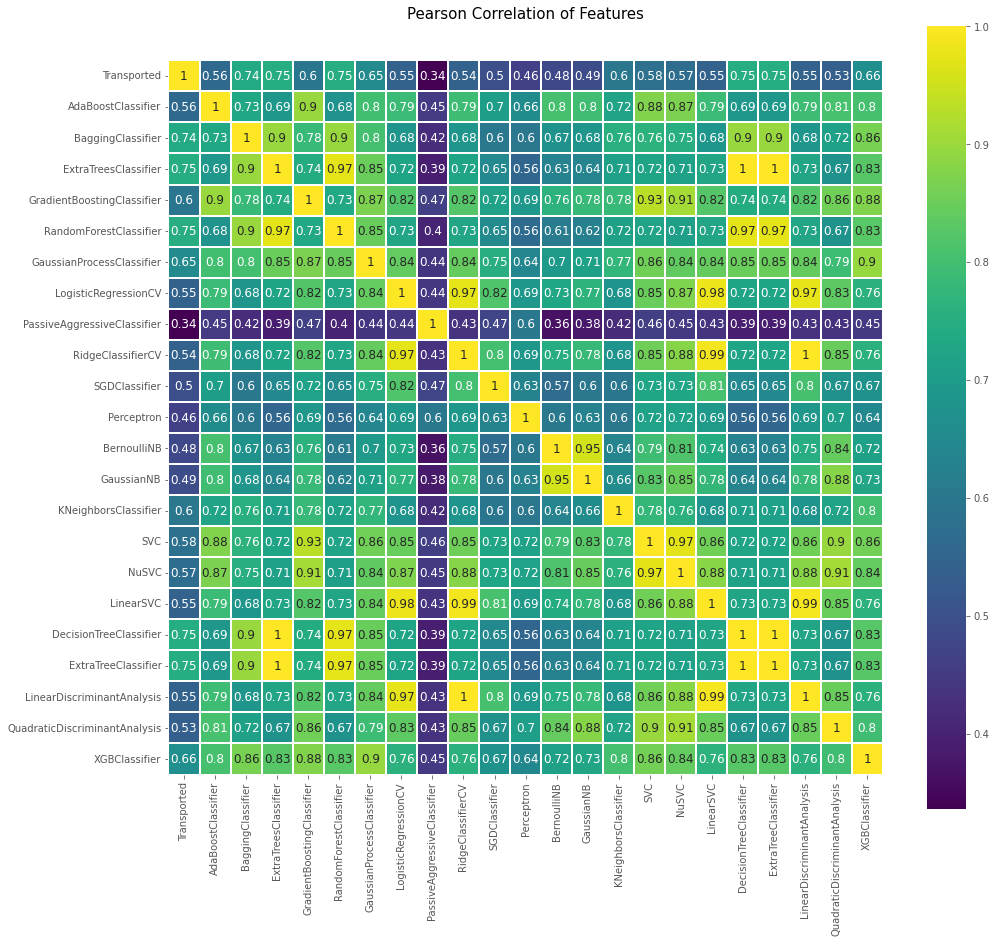

In [5]:
#compare algorithm predictions with each other, for ensemble stacking we are looking for poorly correlated MLA's that also have good accuracy

#correlation heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 16))
    colormap = sns.color_palette("viridis", as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
correlation_heatmap(MLA_predict)

In [6]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None):
#        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [7]:
#function to get the out of fold predictions for each of the base models
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [8]:
#split training data into training and validation set
X_training, X_val, y_training, y_val = train_test_split(train[x_bin], train[Target], test_size=0.3, random_state=0)

## Tune Hyperparameters for ensemble stacking

### LogisticRegression CV

In [9]:
#create lists of values for hyperparameters to tune using param_grid
grid_C = [100, 10, 1.0, 0.1, 0.01]

#split dataset in cross-validation with this splitter class: 
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
LR = linear_model.LogisticRegressionCV()
base_results = model_selection.cross_validate(LR, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
LR.fit(train[x_bin], train[Target])

print('BEFORE LR Parameters: ', LR.get_params())
print("BEFORE LR Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE LR Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE LR Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'Cs': grid_C,  
              'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
           }

#choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(LR, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER LR Parameters: ', tune_model.best_params_)
print("AFTER LR Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER LR Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER LR Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE LR Parameters:  {'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}
BEFORE LR Training w/bin score mean: 77.41
BEFORE LR Test w/bin score mean: 77.21
BEFORE LR Test w/bin score 3*std: +/- 2.40
----------
AFTER LR Parameters:  {'Cs': 100, 'penalty': 'l1', 'solver': 'liblinear'}
AFTER LR Training w/bin score mean: 84.67
AFTER LR Test w/bin score mean: 84.29
AFTER LR Test w/bin score 3*std: +/- 1.97
----------


### K Neighbours Classifier

In [10]:
#create lists of values for hyperparameters to tune using param_grid
grid_neighbors = [1,5,9,13,17,21,30,50]

#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
KN = neighbors.KNeighborsClassifier()
base_results = model_selection.cross_validate(KN, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
KN.fit(train[x_bin], train[Target])

print('BEFORE KN Parameters: ', KN.get_params())
print("BEFORE KN Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE KN Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE KN Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'n_neighbors': grid_neighbors  
           }

#choose best model with grid_search

tune_model = model_selection.GridSearchCV(KN, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER KN Parameters: ', tune_model.best_params_)
print("AFTER KN Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER KN Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER KN Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))


BEFORE KN Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
BEFORE KN Training w/bin score mean: 80.30
BEFORE KN Test w/bin score mean: 75.89
BEFORE KN Test w/bin score 3*std: +/- 2.54
----------
AFTER KN Parameters:  {'n_neighbors': 30}
AFTER KN Training w/bin score mean: 87.44
AFTER KN Test w/bin score mean: 85.78
AFTER KN Test w/bin score 3*std: +/- 2.23


### Random Forest

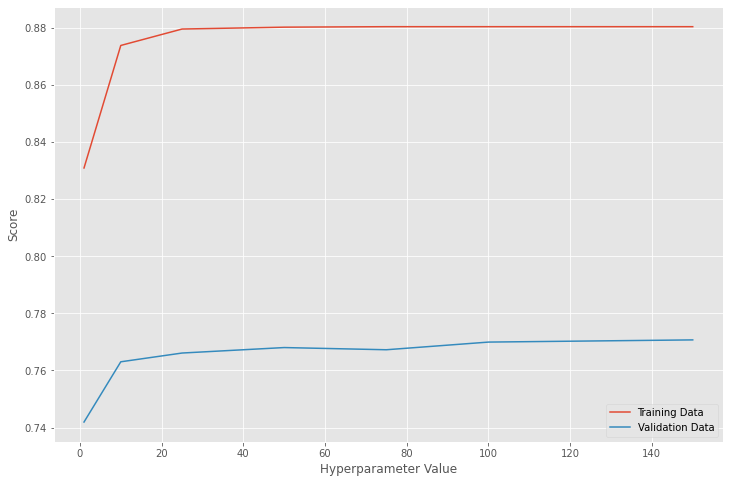

In [11]:
#function to explore individual hyperparameters so that final param grid can be more finely tuned to save computation time
def explore_RF_hyperparameters(hyperparameter, hyperparameter_values, scoring='accuracy'):

    param_grid = [{hyperparameter: hyperparameter_value} for hyperparameter_value in hyperparameter_values]
    score_training_data = []
    score_val_data = []

    for i, _ in enumerate(hyperparameter_values):
        clf = RandomForestClassifier(random_state=0, **param_grid[i])
        clf.fit(X_training, y_training)
        scorer = metrics.get_scorer(scoring)
        score_training_data.append(scorer(clf, X_training, y_training))
        score_val_data.append(scorer(clf, X_val, y_val))

    plt.plot(hyperparameter_values, score_training_data)
    plt.plot(hyperparameter_values, score_val_data)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.show()
    
#varying the number of estimators   
explore_RF_hyperparameters(
    hyperparameter="n_estimators",
    hyperparameter_values = [1, 10, 25, 50, 75, 100, 150]
)

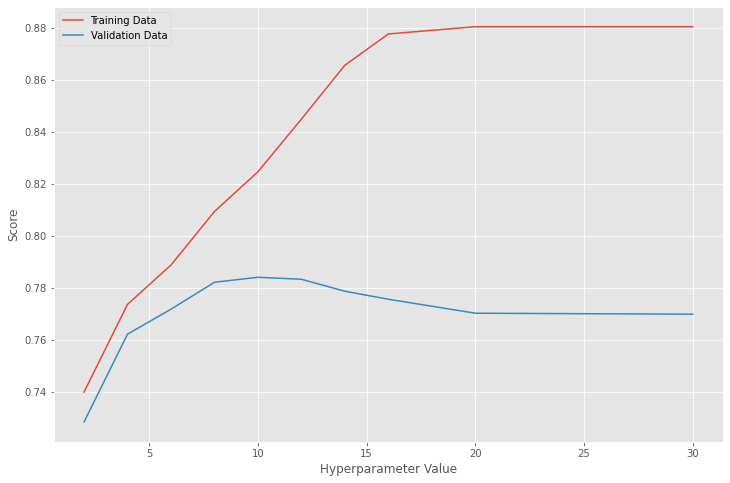

In [12]:
#varying the max depth 
explore_RF_hyperparameters(
    hyperparameter="max_depth",
    hyperparameter_values = [2, 4, 6, 8, 10, 12, 14, 16 , 20, 30]
)

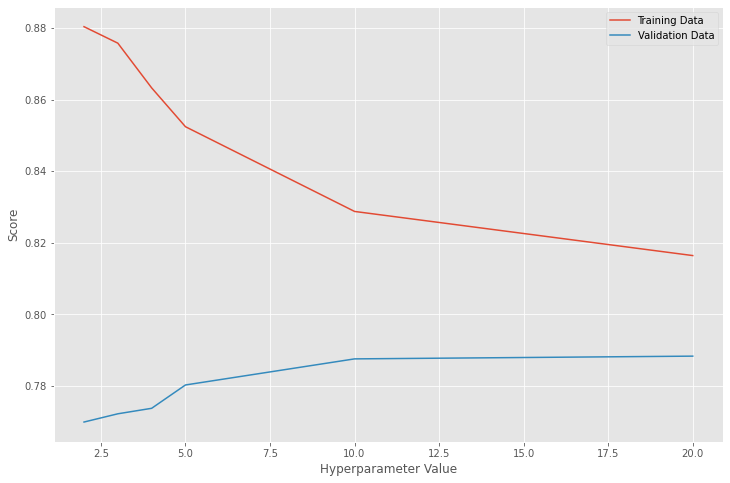

In [13]:
#varying the min samples per split
explore_RF_hyperparameters(
    hyperparameter="min_samples_split",
    hyperparameter_values = [ 2, 3, 4, 5,10,20]
)

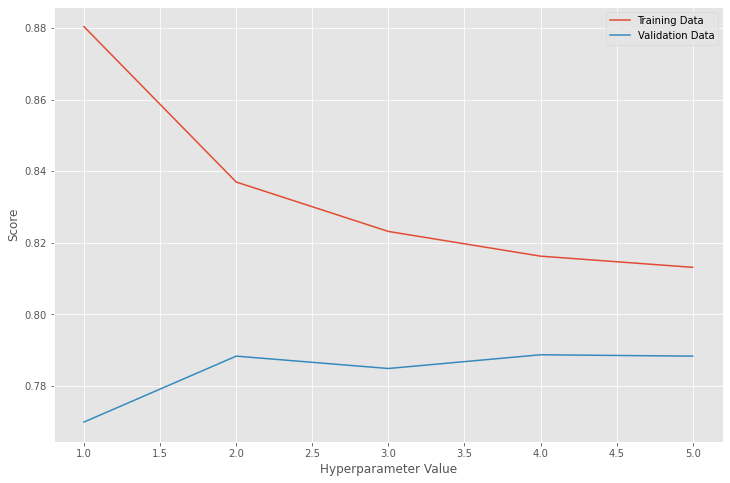

In [14]:
#varying the min samples per leaf
explore_RF_hyperparameters(
    hyperparameter="min_samples_leaf",
    hyperparameter_values = [1, 2, 3, 4, 5]
)

In [15]:
#create lists of values for hyperparameters to tune using param_grid
grid_n_estimator = [ 10, 20, 30]
grid_max_depth = [ 8, 10, 12]
grid_seed = [0]
grid_split = [5,10,15]
grid_leaf = [2,3]

#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
RF = ensemble.RandomForestClassifier()
base_results = model_selection.cross_validate(RF, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
RF.fit(train[x_bin], train[Target])

print('BEFORE RF Parameters: ', RF.get_params())
print("BEFORE RF Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE RF Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE RF Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'n_estimators': grid_n_estimator,  
              'criterion': ['gini', 'entropy'], 
              'max_depth': grid_max_depth,    
              'random_state': grid_seed,
              'min_samples_split': grid_split,
              'min_samples_leaf': grid_leaf,
              'max_features': ['auto', 'sqrt', 'log2']
           }


#choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(RF, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER RF Parameters: ', tune_model.best_params_)
print("AFTER RF Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER RF Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER RF Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


BEFORE RF Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE RF Training w/bin score mean: 88.46
BEFORE RF Test w/bin score mean: 76.89
BEFORE RF Test w/bin score 3*std: +/- 1.91
----------
AFTER RF Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 30, 'random_state': 0}
AFTER RF Training w/bin score mean: 90.23
AFTER RF Test w/bin score mean: 87.10
AFTER RF Test w/bin score 3*std: +/- 1.44
----------


### Extra Trees

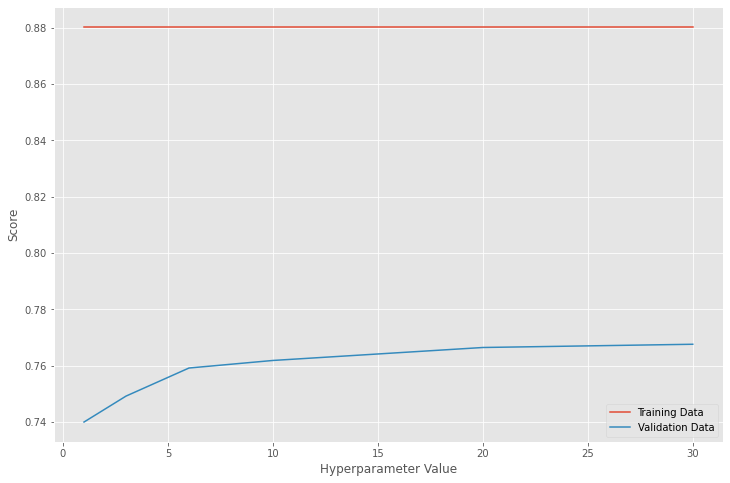

In [16]:
#function to explore individual hyperparameters so that final param grid can be more finely tuned to save computation time
def explore_ET_hyperparameters(hyperparameter, hyperparameter_values, scoring='accuracy'):

    param_grid = [{hyperparameter: hyperparameter_value} for hyperparameter_value in hyperparameter_values]
    score_training_data = []
    score_val_data = []

    for i, _ in enumerate(hyperparameter_values):
        clf = ExtraTreesClassifier(random_state=0, **param_grid[i])
        clf.fit(X_training, y_training)
        scorer = metrics.get_scorer(scoring)
        score_training_data.append(scorer(clf, X_training, y_training))
        score_val_data.append(scorer(clf, X_val, y_val))

    plt.plot(hyperparameter_values, score_training_data)
    plt.plot(hyperparameter_values, score_val_data)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.show()
    
#varying the number of estimators   
explore_ET_hyperparameters(
    hyperparameter="n_estimators",
    hyperparameter_values = [1,3,6, 10, 20,30]
)

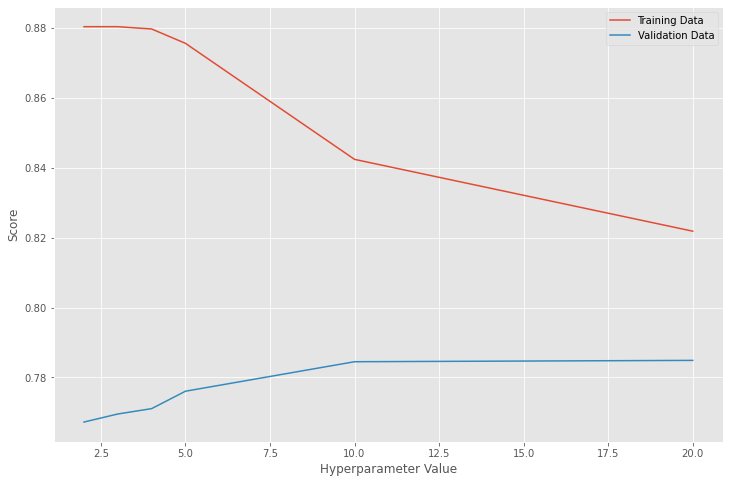

In [17]:
#varying the min samples per split
explore_ET_hyperparameters(
    hyperparameter="min_samples_split",
    hyperparameter_values = [ 2, 3, 4, 5,10,20]
)

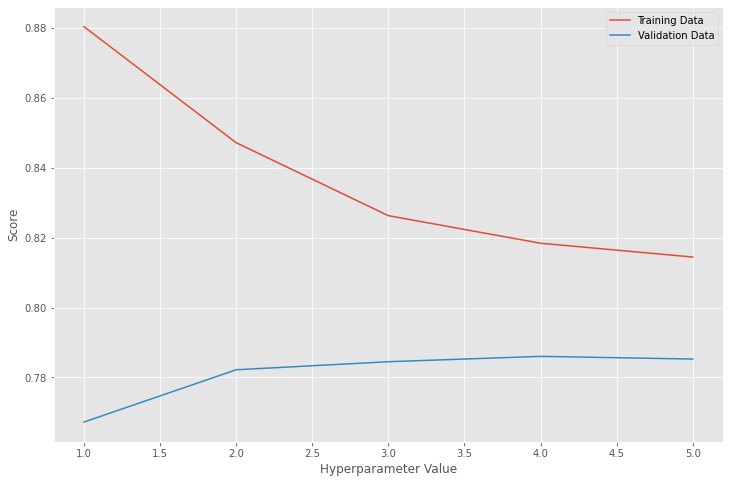

In [18]:
#varying the min samples per leaf
explore_ET_hyperparameters(
    hyperparameter="min_samples_leaf",
    hyperparameter_values = [1, 2, 3, 4, 5]
)

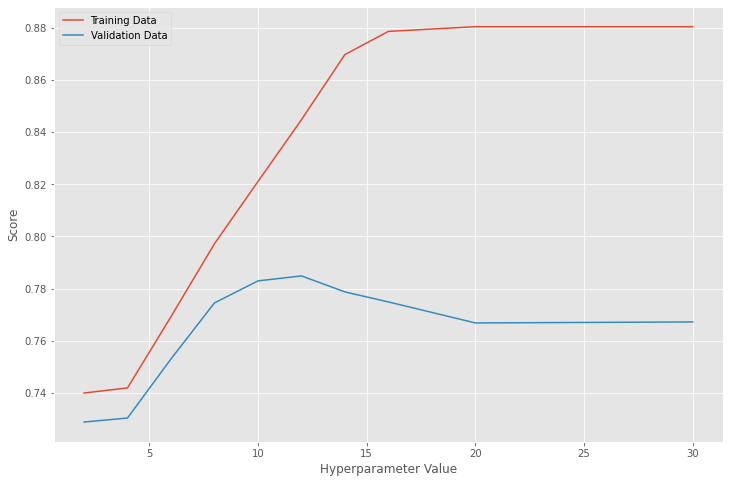

In [19]:
#varying the max depth 
explore_ET_hyperparameters(
    hyperparameter="max_depth",
    hyperparameter_values = [2, 4, 6, 8, 10, 12, 14, 16 , 20, 30]
)

In [20]:
#create lists of values for hyperparameters to tune using param_grid
grid_n_estimator = [ 6, 10, 14]
grid_max_depth = [ 8, 10, 12]
grid_seed = [0]
grid_split = [5,10,15]
grid_leaf = [2,3,4]

#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
ET = ensemble.ExtraTreesClassifier()
base_results = model_selection.cross_validate(ET, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
ET.fit(train[x_bin], train[Target])

print('BEFORE ET Parameters: ', ET.get_params())
print("BEFORE ET Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE ET Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE ET Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'n_estimators': grid_n_estimator,  
              'criterion': ['gini', 'entropy'], 
              'max_depth': grid_max_depth,    
              'random_state': grid_seed,
              'min_samples_split': grid_split,
              'min_samples_leaf': grid_leaf,
              'max_features': ['auto', 'sqrt', 'log2']
           }

#choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(ET, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER ET Parameters: ', tune_model.best_params_)
print("AFTER ET Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER ET Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER ET Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE ET Parameters:  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE ET Training w/bin score mean: 88.46
BEFORE ET Test w/bin score mean: 76.48
BEFORE ET Test w/bin score 3*std: +/- 1.68
----------
AFTER ET Parameters:  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 14, 'random_state': 0}
AFTER ET Training w/bin score mean: 90.82
AFTER ET Test w/bin score mean: 86.82
AFTER ET Test w/bin score 3*std: +/- 1.36
----------


### Ada boost

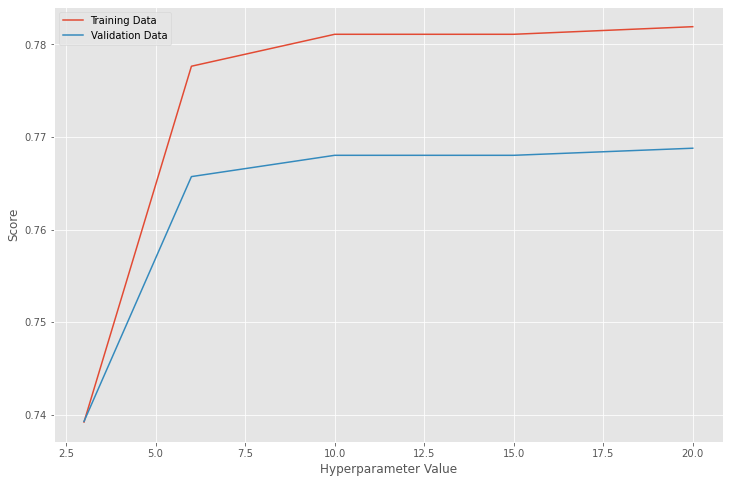

In [21]:
#function to explore individual hyperparameters so that final param grid can be more finely tuned to save computation time
def explore_ADA_hyperparameters(hyperparameter, hyperparameter_values, scoring='accuracy'):

    param_grid = [{hyperparameter: hyperparameter_value} for hyperparameter_value in hyperparameter_values]
    score_training_data = []
    score_val_data = []

    for i, _ in enumerate(hyperparameter_values):
        clf = AdaBoostClassifier(random_state=0, **param_grid[i])
        clf.fit(X_training, y_training)
        scorer = metrics.get_scorer(scoring)
        score_training_data.append(scorer(clf, X_training, y_training))
        score_val_data.append(scorer(clf, X_val, y_val))

    plt.plot(hyperparameter_values, score_training_data)
    plt.plot(hyperparameter_values, score_val_data)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.show()
    
#varying the number of estimators   
explore_ADA_hyperparameters(
    hyperparameter="n_estimators",
    hyperparameter_values = [3,6,10,15,20]
)

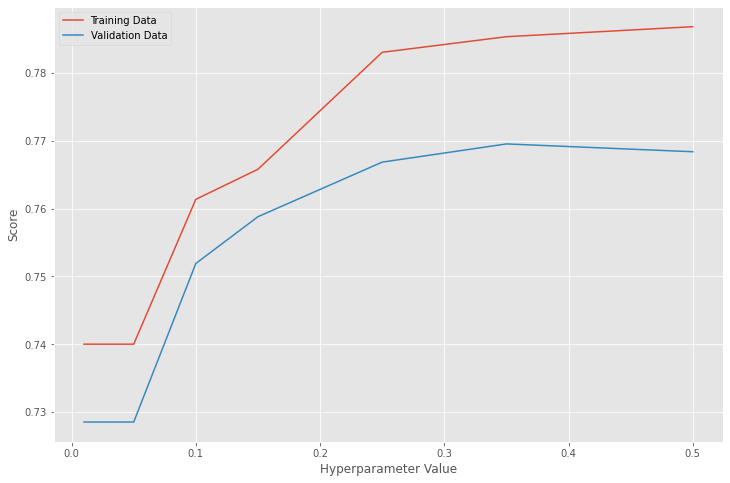

In [22]:
#varying the learning rate   
explore_ADA_hyperparameters(
    hyperparameter="learning_rate",
    hyperparameter_values = [.01, .03, .05, .1, .15, .25, 0.35, 0.5]
)

In [23]:
#create lists of values for hyperparameters to tune using param_grid
grid_n_estimator = [ 6, 8, 10, 12]
grid_learn = [ 0.25, 0.3, 0.35, 0.4]

#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
ADA = ensemble.AdaBoostClassifier()
base_results = model_selection.cross_validate(ADA, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
ADA.fit(train[x_bin], train[Target])

print('BEFORE ADA Parameters: ', ADA.get_params())
print("BEFORE ADA Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE ADA Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE ADA Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'n_estimators': grid_n_estimator,  
              'learning_rate': grid_learn
           }

#choose best model with grid_search:
tune_model = model_selection.GridSearchCV(ADA, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER ADA Parameters: ', tune_model.best_params_)
print("AFTER ADA Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER ADA Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER ADA Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE ADA Parameters:  {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
BEFORE ADA Training w/bin score mean: 78.29
BEFORE ADA Test w/bin score mean: 77.94
BEFORE ADA Test w/bin score 3*std: +/- 2.32
----------
AFTER ADA Parameters:  {'learning_rate': 0.4, 'n_estimators': 12}
AFTER ADA Training w/bin score mean: 83.63
AFTER ADA Test w/bin score mean: 83.21
AFTER ADA Test w/bin score 3*std: +/- 2.65
----------


### SVC

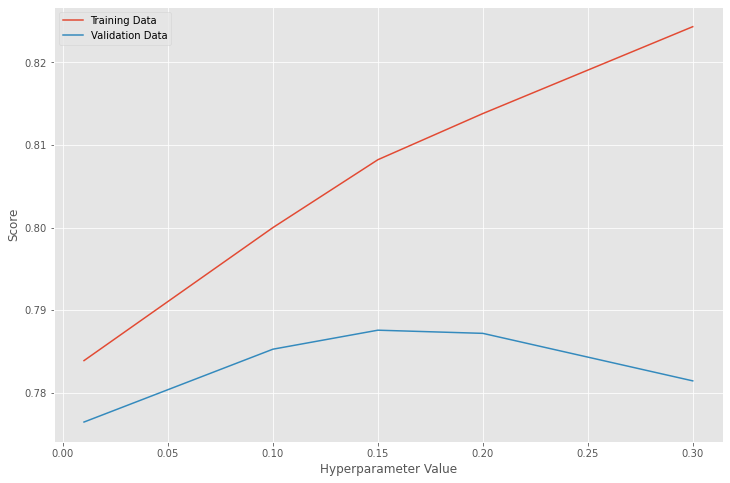

In [24]:
#function to explore individual hyperparameters so that final param grid can be more finely tuned to save computation time
def explore_SVC_hyperparameters(hyperparameter, hyperparameter_values, scoring='accuracy'):

    param_grid = [{hyperparameter: hyperparameter_value} for hyperparameter_value in hyperparameter_values]
    score_training_data = []
    score_val_data = []

    for i, _ in enumerate(hyperparameter_values):
        clf = SVC(random_state=0, **param_grid[i])
        clf.fit(X_training, y_training)
        scorer = metrics.get_scorer(scoring)
        score_training_data.append(scorer(clf, X_training, y_training))
        score_val_data.append(scorer(clf, X_val, y_val))

    plt.plot(hyperparameter_values, score_training_data)
    plt.plot(hyperparameter_values, score_val_data)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.show()
    
#varying gamma 
explore_SVC_hyperparameters(
    hyperparameter="gamma",
    hyperparameter_values = [0.3, 0.2,0.15,0.1,0.01]
)

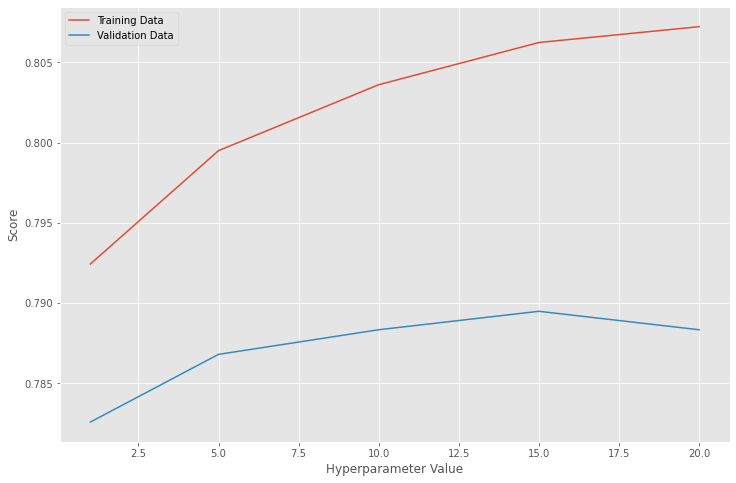

In [25]:
#varying C 
explore_SVC_hyperparameters(
    hyperparameter="C",
    hyperparameter_values = [1,5,10,15,20]
)

In [29]:
#create lists of values for hyperparameters to tune using param_grid
grid_C = [5,10,15]
grid_gamma = [0.125, 0.175,]

#split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#base model
SVC_mla = svm.SVC()
base_results = model_selection.cross_validate(SVC_mla, train[x_bin], train[Target], cv  = cv_split, return_train_score=True)
SVC_mla.fit(train[x_bin], train[Target])

print('BEFORE SVC Parameters: ', SVC_mla.get_params())
print("BEFORE SVC Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE SVC Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE SVC Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#tune hyper-parameters:
param_grid = {'C': grid_C,  
              'gamma': grid_gamma,
              'kernel': ['rbf', 'poly', 'sigmoid']
           }

#choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(SVC_mla, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(train[x_bin], train[Target])

print('AFTER SVC Parameters: ', tune_model.best_params_)
print("AFTER SVC Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER SVC Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER SVC Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE SVC Parameters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
BEFORE SVC Training w/bin score mean: 79.16
BEFORE SVC Test w/bin score mean: 78.62
BEFORE SVC Test w/bin score 3*std: +/- 2.33
----------
AFTER SVC Parameters:  {'C': 5, 'gamma': 0.125, 'kernel': 'rbf'}
AFTER SVC Training w/bin score mean: 89.37
AFTER SVC Test w/bin score mean: 84.52
AFTER SVC Test w/bin score 3*std: +/- 2.07
----------


## Create Ensemble

In [30]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_estimators': 30,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split' : 10,
    'random_state' : 0,
    'criterion' : 'entropy',
    'max_features' : 'auto'
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 14,
    'max_features': 'auto',
    'random_state' : 0,    
    'max_depth': 12,
    'min_samples_leaf': 2,
    'min_samples_split' : 10,
    'criterion': 'entropy'
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 12,
    'learning_rate' : 0.4
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 150,
    'max_depth': 4,
    'learning_rate': 0.05,
    'criterion' : 'mse',
    'loss' : 'exponential'
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'gamma' : 0.125,
    'C' : 5
    }

# LogisticRegressionCV parameters 
lr_params = {
    'solver' : 'liblinear',
    'penalty' : 'l1',
    'Cs' : 100
    }

# K Neighbours Classifier parameters 
kn_params = {
    'n_neighbors' : 30
    }

In [32]:
# Create objects that represent our models
rf = SklearnHelper(clf=RandomForestClassifier, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, params=gb_params)
svc = SklearnHelper(clf=SVC, params=svc_params)
kn = SklearnHelper(clf=KNeighborsClassifier, params=kn_params)
lr = SklearnHelper(clf=LogisticRegressionCV, params=lr_params)

In [33]:
# Create Numpy arrays of train, test and target dataframes to feed into our models
y_train = train['Transported'].ravel()
x_train = train[x_bin].values # Creates an array of the train data
x_test = test[x_bin].values # Creats an array of the test data

In [34]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
kn_oof_train, kn_oof_test = get_oof(kn,x_train, y_train, x_test) # K Neighbours Classifier
lr_oof_train, lr_oof_test = get_oof(lr,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [35]:
#calculate feature importances
rf_feature = rf.feature_importances(x_train,y_train)
#et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.08149851 0.12141756 0.0263793  0.03566973 0.0617103  0.06694308
 0.04148718 0.10507952 0.10221604 0.22752182 0.13007695]
[0.16666667 0.08333333 0.         0.         0.16666667 0.
 0.         0.25       0.16666667 0.08333333 0.08333333]
[0.03516187 0.05529047 0.01329405 0.0163035  0.04192106 0.07767723
 0.04369778 0.0738312  0.0737358  0.45403183 0.1150552 ]


In [38]:
#'SVC' and 'KNN' and 'LR' object has no attribute 'feature_importances_' so cant do this for it
rf_features = [0.08149851, 0.12141756, 0.0263793,  0.03566973, 0.0617103,  0.06694308, 0.04148718, 0.10507952, 0.10221604, 0.22752182, 0.13007695]
#et_features = [0.10643321, 0.21578448, 0.02627657, 0.02819634, 0.00356097, 0.10891651, 0.04835752, 0.04423012, 0.11609769, 0.09899834, 0.1021764,  0.01659244, 0.08437942]
ada_features = [0.16666667, 0.08333333, 0, 0, 0.16666667, 0, 0, 0.25, 0.16666667, 0.08333333, 0.08333333]
gb_features = [0.03516087, 0.05529047, 0.01330023, 0.01630864, 0.04191415, 0.07767739, 0.04371369, 0.07383201, 0.07372111, 0.45403183, 0.11504961]

In [39]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': x_bin,
     'Random Forest feature importances': rf_features,
     #'Extra Trees  feature importances': et_features,
     'AdaBoost feature importances': ada_features,
     'Gradient Boost feature importances': gb_features
    })

In [40]:
# Scatter plot of feature importances
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [41]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [42]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [43]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,HomePlanet,0.081499,0.166667,0.035161,0.094442
1,CryoSleep,0.121418,0.083333,0.055290,0.086680
2,Destination,0.026379,0.000000,0.013300,0.013227


In [44]:
#a plot of the average feature importances across the models
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [45]:
#create base predictions
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     #'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel(),
     'SVC': svc_oof_train.ravel(),
     'KNeighbours': kn_oof_train.ravel(),
     'LogisticRegression': lr_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,AdaBoost,GradientBoost,SVC,KNeighbours,LogisticRegression
0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#plot correlation between the models
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [47]:
#create new train and test sets with the guesses from our ensemble
x_train_ensemble = np.concatenate(( lr_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, kn_oof_train), axis=1)
x_test_ensemble = np.concatenate(( lr_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, kn_oof_test), axis=1)

## Tune Hyperparameters for XGBoost

In [55]:
X_training_ensemble, X_val_ensemble, y_training, y_val = train_test_split(x_train_ensemble, y_train, test_size=0.3, random_state=42)

[15:49:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:55] WARNING: /Users/runner/miniforge3/cond

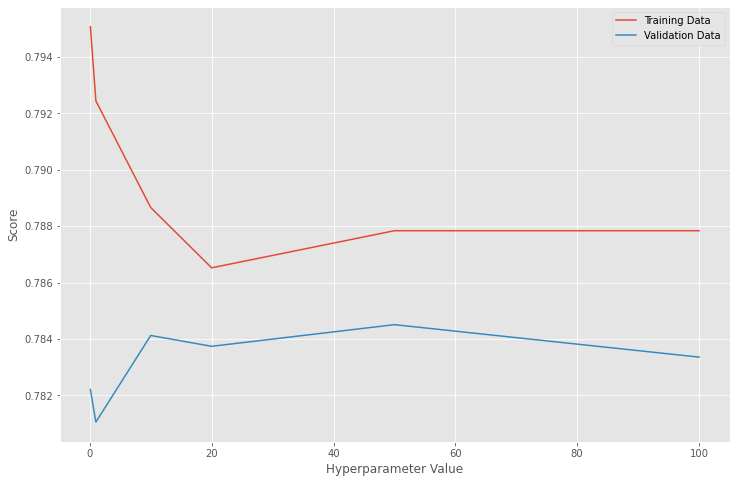

In [56]:
#function to explore individual hyperparameters so that final param grid can be more finely tuned to save computation time
def explore_XGB_hyperparameters(hyperparameter, hyperparameter_values, scoring='accuracy'):

    param_grid = [{hyperparameter: hyperparameter_value} for hyperparameter_value in hyperparameter_values]
    score_training_data = []
    score_val_data = []

    for i, _ in enumerate(hyperparameter_values):
        clf = XGBClassifier(random_state=0, **param_grid[i])
        clf.fit(X_training_ensemble, y_training)
        scorer = metrics.get_scorer(scoring)
        score_training_data.append(scorer(clf, X_training_ensemble, y_training))
        score_val_data.append(scorer(clf, X_val_ensemble, y_val))

    plt.plot(hyperparameter_values, score_training_data)
    plt.plot(hyperparameter_values, score_val_data)
    plt.legend(['Training Data', 'Validation Data'])
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.show()
    
#varying gamma 
explore_XGB_hyperparameters(
    hyperparameter="gamma",
    hyperparameter_values = [0.1,1,10,20,50,100]
)

[15:49:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:58] WARNING: /Users/runner/miniforge3/cond

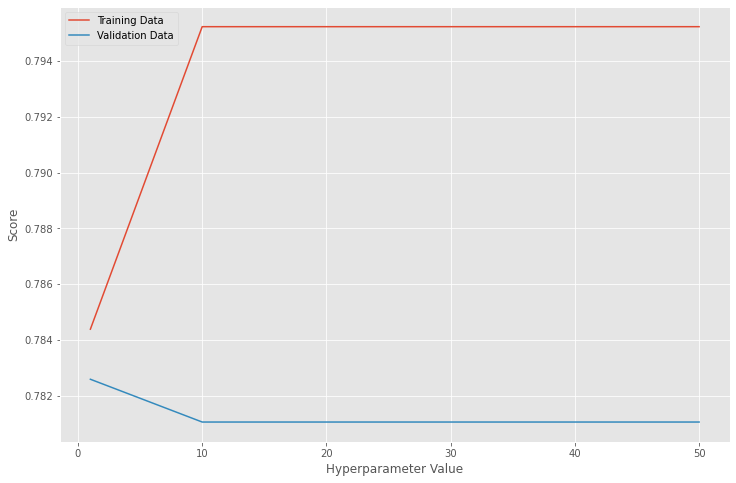

In [57]:
#varying max depth 
explore_XGB_hyperparameters(
    hyperparameter="max_depth",
    hyperparameter_values = [1,10,20,50]
)

[15:49:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:00] WARNING: /Users/runner/miniforge3/cond

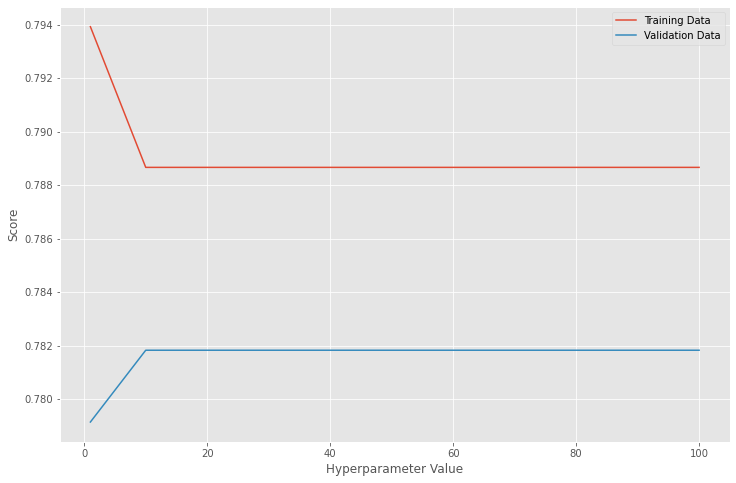

In [58]:
#varying reg_alpa 
explore_XGB_hyperparameters(
    hyperparameter="reg_alpha",
    hyperparameter_values = [1,10,20,50,100]
)

[15:50:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:01] WARNING: /Users/runner/miniforge3/cond

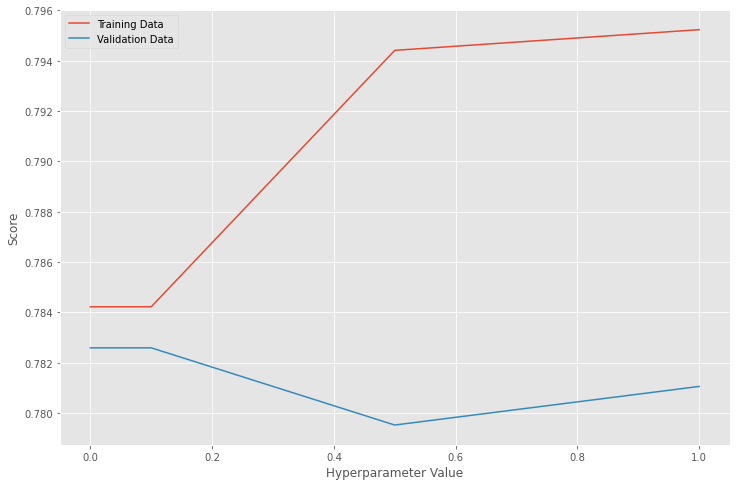

In [59]:
#varying colsample_bytree 
explore_XGB_hyperparameters(
    hyperparameter="colsample_bytree",
    hyperparameter_values = [0,0.1,0.5,1]
)

[15:50:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:03] WARNING: /Users/runner/miniforge3/cond

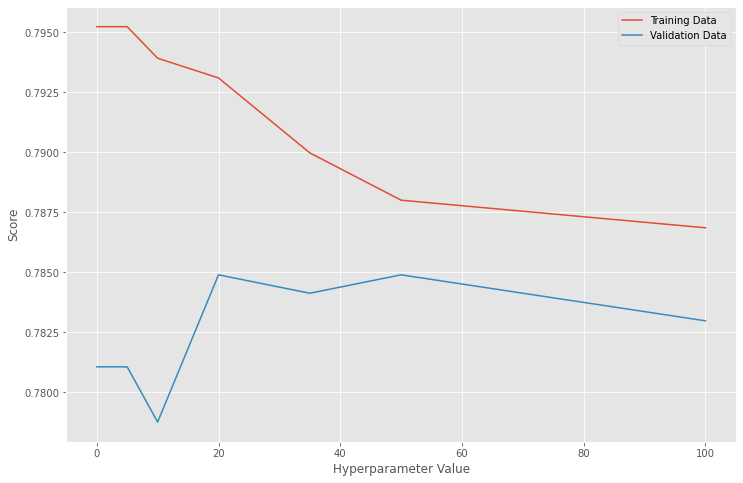

In [60]:
#varying min_child_weight 
explore_XGB_hyperparameters(
    hyperparameter="min_child_weight",
    hyperparameter_values = [0,5,10,20,35,50,100]
)

[15:50:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:05] WARNING: /Users/runner/miniforge3/cond

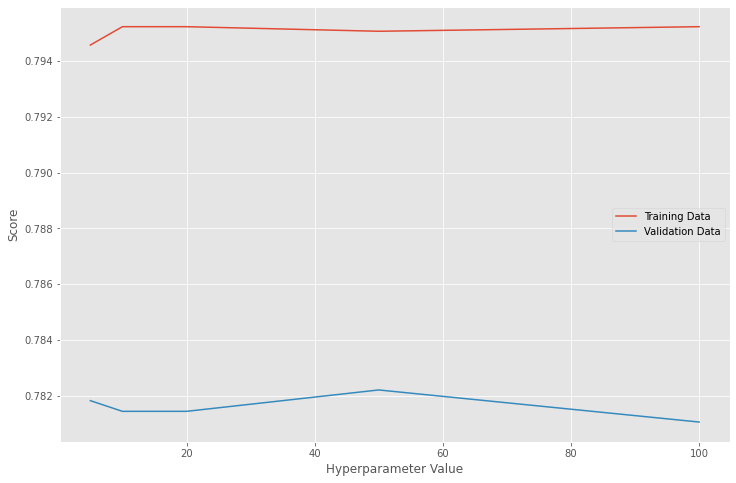

In [61]:
#varying n_estimators 
explore_XGB_hyperparameters(
    hyperparameter="n_estimators",
    hyperparameter_values = [5,10,20,50,100]
)

[15:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:18] WARNING: /Users/runner/miniforge3/cond

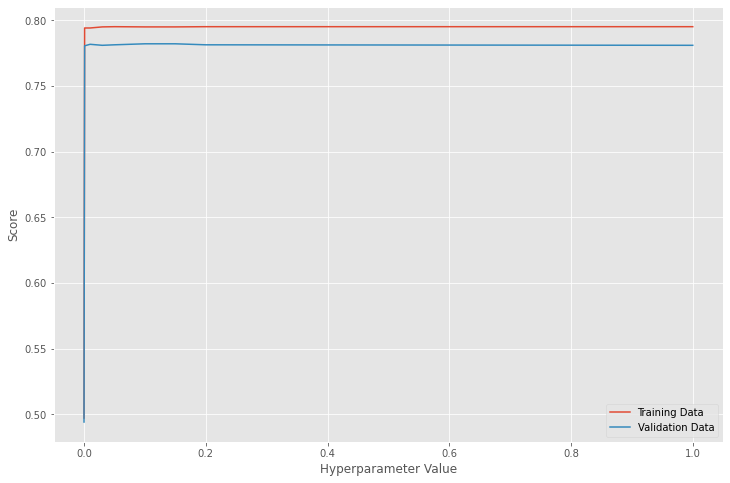

In [62]:
#varying learning_rate 
explore_XGB_hyperparameters(
    hyperparameter="learning_rate",
    hyperparameter_values = [0,0.001,0.01,0.03,0.05,0.1,0.15,0.2,1]
)

[15:50:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:21] WARNING: /Users/runner/miniforge3/cond

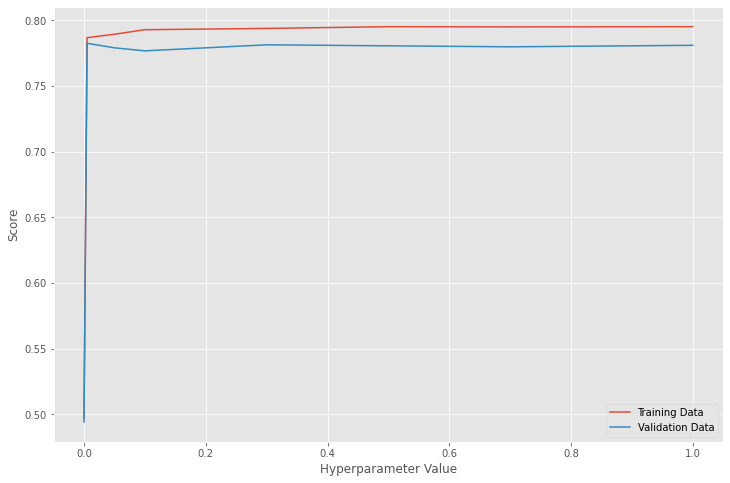

In [63]:
#varying subsample 
explore_XGB_hyperparameters(
    hyperparameter="subsample",
    hyperparameter_values = [0,0.005,0.05, 0.1,0.3,0.5,0.7,1]
)

In [64]:
#create hyperparameter space for the values during tuning to be selected from
space={'max_depth': hp.quniform("max_depth", 1, 10, 1),
        'gamma': hp.uniform ('gamma', 20,80),
        'reg_alpha' : hp.quniform('reg_alpha', 1,50,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,0.5),
        'min_child_weight' : hp.quniform('min_child_weight', 15, 60, 1),
        'n_estimators': hp.quniform('n_estimators', 20, 50, 1),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'subsample' : hp.uniform('subsample', 0,1),
        'seed': 0
    }

In [65]:
#function to run XGBClassifier with hyperparameter values from 'space' and report the accuracy
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_training_ensemble, y_training), ( X_val_ensemble, y_val)]
    
    clf.fit(X_training_ensemble, y_training,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val_ensemble)
    accuracy = accuracy_score(y_val, pred>0.5)
    print (accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [66]:
#run a large number of trials constantly varying the hyperparameters and record the best
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681          

0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.776840490797546                                                               
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681          

0.776840490797546                                                               
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.776840490797546                                                               
0.7772239263803681                                                              
0.776840490797546                                                               
0.7772239263803681                                                              
0.7772239263803681                                                              
0.7772239263803681                                                              
0.776840490797546                                                               
0.7772239263803681          

## Submit Result

In [67]:
#ensemble stacking method
gbm = xgb.XGBClassifier(
 learning_rate = 0.21281278494916178,
 n_estimators= 35,
 max_depth= 3,
 min_child_weight= 40,
 gamma=67.88907727191975,                        
 subsample=0.2578100761390425,
 colsample_bytree=0.28157458518226625,
 #objective= 'binary:logistic',
 nthread= -1,
 reg_alpha=19,
 reg_lambda=0.6944927032686287
 #scale_pos_weight=1
).fit(x_train_ensemble, y_train)
predictions = gbm.predict(x_test_ensemble)

[15:51:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [68]:
#Generate Submission File 
Submission = pd.DataFrame({ 'PassengerId': test.PassengerId,'Transported': predictions })
Submission.to_csv("submission.csv", index=False)